In [6]:
import imageio
import os

In [10]:
# Load video
video_path = 'utah_waterlab_videos\waterlab1.mp4'
reader = imageio.get_reader(video_path)


<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:2: SyntaxWarning: invalid escape sequence '\w'
C:\Users\mehdih\AppData\Local\Temp\ipykernel_30208\962637368.py:2: SyntaxWarning: invalid escape sequence '\w'
  video_path = 'utah_waterlab_videos\waterlab1.mp4'


In [11]:

# Directory to save frames
output_dir = 'frames'
os.makedirs(output_dir, exist_ok=True)


In [14]:

# Extract frames
for i, frame in enumerate(reader):
    imageio.imwrite(f'{output_dir}/frame_{i:04d}.png', frame)

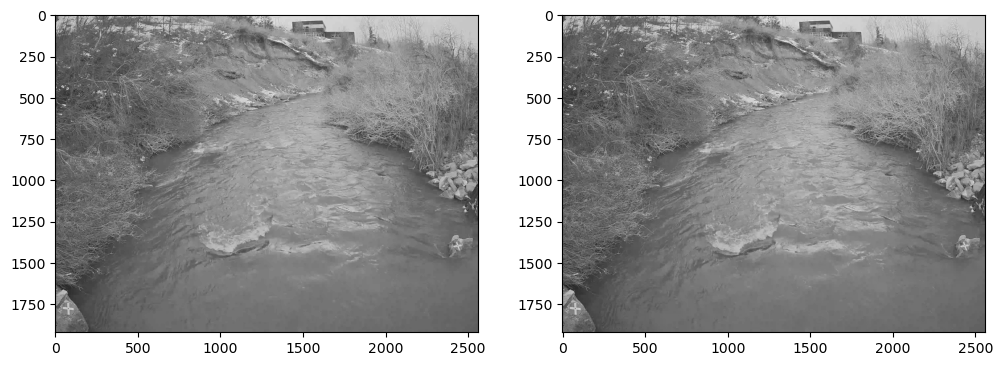

In [15]:
from openpiv import tools, pyprocess, validation, filters, scaling
import matplotlib.pyplot as plt
import numpy as np

# Load consecutive frames
frame_a = tools.imread('frames/frame_0000.png')
frame_b = tools.imread('frames/frame_0001.png')

# Display the images
fig, ax = plt.subplots(1, 2, figsize=(12, 10))
ax[0].imshow(frame_a, cmap=plt.cm.gray)
ax[1].imshow(frame_b, cmap=plt.cm.gray)
plt.show()


In [16]:
# Set PIV parameters
winsize = 32      # Interrogation window size in pixels
searchsize = 38   # Search area size in the second frame
overlap = 17      # Overlap between interrogation windows
dt = 0.02         # Time interval between frames in seconds

# Calculate velocity field using cross-correlation
u0, v0, sig2noise = pyprocess.extended_search_area_piv(
    frame_a.astype(np.int32),
    frame_b.astype(np.int32),
    window_size=winsize,
    overlap=overlap,
    dt=dt,
    search_area_size=searchsize,
    sig2noise_method='peak2peak',
)

In [17]:
# Get the coordinates of the vector field
x, y = pyprocess.get_coordinates(
    image_size=frame_a.shape,
    search_area_size=searchsize,
    overlap=overlap,
)

In [18]:
# Apply signal-to-noise ratio validation
invalid_mask = validation.sig2noise_val(
    sig2noise,
    threshold=1.05,
)

# Replace outliers with local mean
u2, v2 = filters.replace_outliers(
    u0, v0,
    invalid_mask,
    method='localmean',
    max_iter=3,
    kernel_size=3,
)

In [19]:
scaling_factor = 96.52  # Scale factor: pixels per millimeter
x, y, u3, v3 = scaling.uniform(
    x, y, u2, v2,
    scaling_factor=scaling_factor,
)

# Adjust the coordinates so the origin is in the bottom left
x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)

In [20]:
# Save the velocity vector field to a file
tools.save('velocity_field.txt', x, y, u3, v3, invalid_mask)

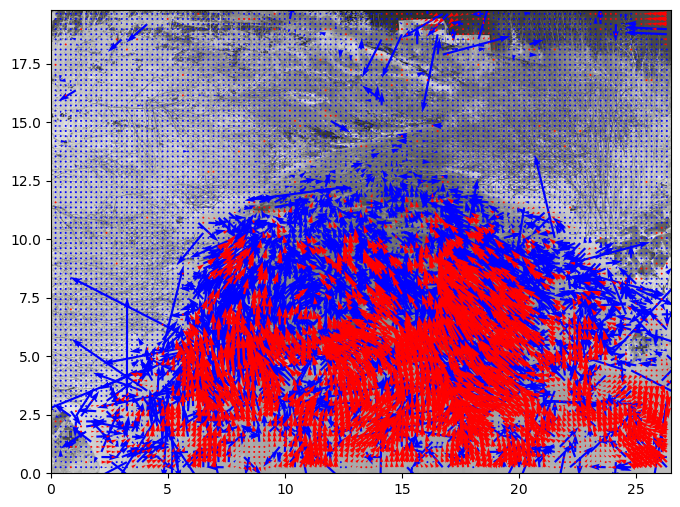

In [21]:
# Plot the velocity field over the first frame
fig, ax = plt.subplots(figsize=(8, 8))
tools.display_vector_field(
    'velocity_field.txt',
    ax=ax,
    scaling_factor=scaling_factor,
    scale=50,  # Defines the length of arrows
    width=0.0035,  # Thickness of arrows
    on_img=True,  # Overlay on the image
    image_name='frames/frame_0000.png',
)
plt.show()